In [1]:
# Load the TensorBoard notebook extension
#%load_ext tensorboard
#http://fnl.es/a-quick-reference-for-working-with-tensorflow.html

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import gym
from IPython import display as ipythondisplay
from IPython.display import clear_output
from pyvirtualdisplay import Display

import tensorflow.compat.v1 as tf
from collections import deque
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input , BatchNormalization, Concatenate, LayerNormalization, LSTM,Reshape
from  tensorflow.compat.v1.keras.layers import CuDNNLSTM #https://www.tensorflow.org/api_docs/python/tf/compat/v1/keras/layers/CuDNNLSTM
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp
import random
import tqdm
import pandas as pd
    
tf.disable_eager_execution()
import math
from datetime import datetime

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.config.experimental.list_physical_devices('GPU'))
tf.debugging.set_log_device_placement(True)
#strategy = tf.distribute.MirroredStrategy()


Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
tf.reset_default_graph()
np.random.seed(0)
tf.set_random_seed(0)
random.seed(0)


In [5]:
class Agent:
    def __init__(self, name, state_shape, env, sess, batch, reuse=False):
        with tf.name_scope(name):
            self.name = name
            self.reuse = reuse
            self.env = env
            self.batch_size = batch

            inputs = Input(shape=state_shape)
            x = Dense(512, activation='relu', name ="inp1", kernel_initializer=tf.keras.initializers.VarianceScaling(scale=1))(inputs) #64
            rnn_in = Reshape((1 ,x.shape[1]), input_shape=x.shape)(x)
            x = LSTM(128, return_sequences=False, name ="lstm_enc_1")(rnn_in)
            #x = CuDNNLSTM(128, return_sequences=False, name ="lstm_enc_1")(rnn_in) #With GPU

            mu = Dense(units=env.action_space.shape[0], activation=tf.nn.tanh,name='actor_mu' )(x)
            sigma = Dense(units=env.action_space.shape[0], activation=tf.nn.softplus, name='actor_sigma' )(x)
            mu, sigma = tf.squeeze(mu*2), tf.squeeze(sigma +  1e-5)
            normal_dist = tfp.distributions.Normal(mu, sigma)
            action = tf.clip_by_value(normal_dist.sample(1), env.action_space.low[0], env.action_space.high[0])


            state_value = Dense(1, activation='linear', name ="v")(x)
            self.network = Model(inputs=inputs, outputs=[action, state_value,mu, sigma])

            self.state_t = tf.placeholder('float32', [None,] + list(state_shape))
            self.agent_outputs = self.symbolic_step(self.state_t)

    def symbolic_step(self, state_t):
        act,s,m, sig = self.network(state_t)
        return act, s[:,0], m, sig

    def sample_actions(self, state_t):

        act,_,_,_= sess.run(self.agent_outputs, {self.state_t: state_t})
        return act


In [6]:
class PendulumA3C:
    def __init__(self, sess,env, agent, beta, lr,entropyF,tr,batch):
        self.sess =sess

        self.filepath = "D:\\Artificial_Intelligence\\RL\\AvrReward_InvertedPendulum\\data.txt"
        self.batch_size =batch
        self.Training= tr
        self.learning_rate= lr
        self.entropy_factor = entropyF

        self.rewards_history = []
        self.entropy_history = []
        self.actor_history =[]
        self.critic_history =[]
        self.advantage_history = []
        self.target_history =[]
        self.v_history =[]
        self.v__history =[]
        self.actionList =[]

        self.reward_step =0
        
        self.AVGR=[0 for i in range(self.batch_size)]
        self.env = env
        self.agent = agent
        self.beta = beta
        
        self.obs_shape = self.env.observation_space.shape
        self.n_actions = self.env.action_space.shape[0]

        print("Observation shape:", self.obs_shape)
        print("Num actions:", self.n_actions)
        
        self.AVR_REWARD_TENSOR =  tf.placeholder('float32', [None,])
        self.states_ph = tf.placeholder('float32', [None,] + list(self.obs_shape))    
        self.next_states_ph = tf.placeholder('float32', [None,] + list(self.obs_shape))
        self.actions_ph = tf.placeholder('float32', (None,))
        self.rewards_ph = tf.placeholder('float32', (None,))
        
        self.act, self.state_values,self.mu, self.sigma = self.agent.symbolic_step(self.states_ph)
        self.next_act, self.next_state_values, self.next_mu, self.next_sigma = self.agent.symbolic_step(self.next_states_ph)
        
        self.target_state_values = self.rewards_ph - self.AVR_REWARD_TENSOR + self.next_state_values
        self.td_error = self.target_state_values - self.state_values
        
        self.normal_dist = tfp.distributions.Normal(self.mu, self.sigma)
        self.entropy =  self.normal_dist.entropy() 
        
        self.actor_loss = -tf.reduce_mean((self.normal_dist.log_prob(self.actions_ph) * tf.stop_gradient(self.td_error)) + self.entropy_factor*self.entropy)
        self.critic_loss = tf.reduce_mean((self.state_values - tf.stop_gradient(self.target_state_values))**2, axis=0)
        self.train_step = tf.train.AdamOptimizer(self.learning_rate).minimize(self.actor_loss + self.critic_loss)

        
    def evaluate(self, n_games=1):
        game_rewards = []
        for _ in range(n_games):
            state = self.env.reset()

            total_reward = 0
            while True:
                action = self.agent.sample_actions([state])
                state, reward, done, info = self.env.step(action)
                total_reward += reward
                if done:
                    break
            game_rewards.append(total_reward)

        self.rewards_history.append(np.mean(game_rewards))
        self.reward_step +=1

        return game_rewards


    def train(self,batch_states,batch_actions,batch_next_states,batch_rewards):
        batch_actions = np.array(batch_actions).reshape(self.batch_size,)
        feed_dict = {
            self.states_ph: batch_states,
            self.actions_ph: batch_actions,
            self.next_states_ph: batch_next_states,
            self.rewards_ph: batch_rewards,
            self.AVR_REWARD_TENSOR: self.AVGR
            }

        _, ent_t,act,crit,td_error,targ,rewards,v,v_,average_reward_list = sess.run([self.train_step, self.entropy,self.actor_loss ,self.critic_loss,self.td_error,
                                                 self.target_state_values,self.rewards_ph,self.state_values,self.next_state_values,self.AVR_REWARD_TENSOR], feed_dict)

        self.entropy_history.append(np.mean(ent_t))
        self.actor_history.append(np.mean(act))
        self.critic_history.append(np.mean(crit))
        self.advantage_history.append(np.mean(td_error))
        self.target_history.append(np.mean(targ))
        self.v_history.append(np.mean(v))
        self.v__history.append(np.mean(v_))
        
        for a in batch_actions:
            self.actionList.append(a)
        
        """print("rewards : ",rewards)
        print("v :",v)
        print("v_ :",v_)
        print("average_reward_list",average_reward_list)
        print("targ",targ)
        print("td_error",td_error)"""
        
        self.AVGR = self.AVGR + self.beta*td_error
        
        
    def ewma(self,x, span=100):
        return pd.DataFrame({'x':np.asarray(x)}).x.ewm(span=span).mean().values

    def plots(self,save,name):
        ipythondisplay.clear_output(wait=True)
        fig1 = plt.gcf()
        plt.figure(figsize=[35,13])
        plt.subplot(2,4,1)
        plt.plot(self.rewards_history, label='reward')
        plt.plot(self.ewma(np.array(self.rewards_history), span=10), marker='.', label='rewards ewma@10')
        plt.title("Session rewards"); plt.grid(); plt.legend()

        plt.subplot(2,4,2)
        plt.plot(self.actor_history, label='Actor Loss')
        plt.plot(self.ewma(np.array(self.actor_history), span=10), marker='.', label='Actor Loss ewma@10')
        plt.title("Policy Function"); plt.grid(); plt.legend()  

        plt.subplot(2,4,3)
        plt.plot(self.entropy_history, label='Entropy')
        plt.plot(self.ewma(np.array(self.entropy_history), span=10), marker='.', label='Entropy ewma@10')
        plt.title("Policy Function"); plt.grid(); plt.legend()      

        plt.subplot(2,4,4)
        plt.plot(self.target_history, label='Target ')
        plt.plot(self.v_history, label='V')
        plt.plot(self.v__history, label='V_')
        plt.title("Target/V/V_"); plt.grid(); plt.legend()

        plt.subplot(2,4,5)
        plt.plot(self.advantage_history, label='Advantage')
        plt.title("Advantage"); plt.grid(); plt.legend()  

        plt.subplot(2,4,6)
        plt.plot(self.critic_history, label='Critic Loss')
        plt.plot(self.ewma(np.array(self.critic_history), span=10), marker='.', label='Critic Loss ewma@10')
        plt.title("Value function"); plt.grid(); plt.legend()   

        plt.subplot(2,4,7)
        plt.plot(self.actionList, label='Actions')
        plt.title("Actions"); plt.grid(); plt.legend()  
        
        
        if save:
            
            plt.savefig('D:\\Artificial_Intelligence\\RL\\AvrReward_InvertedPendulum\\'+name)
            
        plt.show()




In [7]:
class EnvBatch:
    def __init__(self, n_envs = 10):
        self.envs = [gym.make("Pendulum-v0").env for _ in range(n_envs)]

    def reset(self):
        return np.array([env.reset() for env in self.envs])
  
    def step(self, actions):

        results = [env.step([a]) for env, a in zip(self.envs, actions)]
        new_obs, rewards, done, infos = map(np.array, zip(*results))
    
        return new_obs, rewards, done, infos


In [8]:
config = tf.ConfigProto(device_count = {'GPU': 0})
sess = tf.Session(graph= tf.get_default_graph(), config = config )
tf.keras.backend.set_session(sess)
RESET = 1


In [9]:
env_init = gym.make("Pendulum-v0")
batch = 10
training = 2000000

LR_List =[0.00001]#0.00001
Entropy =[0.005]#0.01
Beta_List =[0.1]#0.1


pendulumA3CList=[]
HYPERPARAMETERS = []
i = 0
for lr in LR_List:
    for etrp in Entropy:
        for b in Beta_List:
            pendulumA3CList.append(PendulumA3C(sess,env_init, Agent("agent"+str(i), env_init.observation_space.shape, env_init, sess,batch), b,lr,etrp,training,batch)) 
            HYPERPARAMETERS.append(["lr_{}__Entropy_{}__Beta_{}".format(lr,etrp,b)])
            print(HYPERPARAMETERS[-1][0])
            i = i +1            
            
print("pendulumA3CList size : ",len(pendulumA3CList))

pendulumA3C= pendulumA3CList[0]

Observation shape: (3,)
Num actions: 1
lr_1e-05__Entropy_0.005__Beta_0.1
pendulumA3CList size :  1


In [10]:

if (RESET == 1):
    # ************ RESET everything **************************
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    f=open(pendulumA3C.filepath, "w")
    f.write("")
    f.close()
else:
    # ************ LOAD everything **************************
    saver = tf.train.Saver()
    saver.restore(sess, tf.train.latest_checkpoint('D:\\Artificial_Intelligence\\RL\\AvrReward_InvertedPendulum\\'))

# Validate

rewards = pendulumA3C.evaluate(n_games=3)


env_batch = EnvBatch(batch)
batch_obs = env_batch.reset()
batch_actions = pendulumA3C.agent.sample_actions(batch_obs)
batch_next_obs, batch_rewards, batch_done, _ = env_batch.step(batch_actions)

print(rewards)
print("State shape:", batch_obs.shape)
print("Actions:", batch_actions)
print("Rewards:", batch_rewards)
print("Done:", batch_done)

#Initialize
env_batch = EnvBatch(batch)

[-1588.9446004452855, -1738.7588136987426, -1800.4574639995121]
State shape: (10, 3)
Actions: [[-0.8451709  -0.62729794 -0.08917791 -0.51696765 -0.07283467 -0.12823251
  -1.1358721   0.7614567  -0.4258387  -0.37468776]]
Rewards: [[-1.0919725 -1.0916517 -1.0912662 -1.0915254 -1.0912635 -1.0912746
  -1.0925484 -1.091838  -1.0914395 -1.0913986]]
Done: [False]


<Figure size 432x288 with 0 Axes>

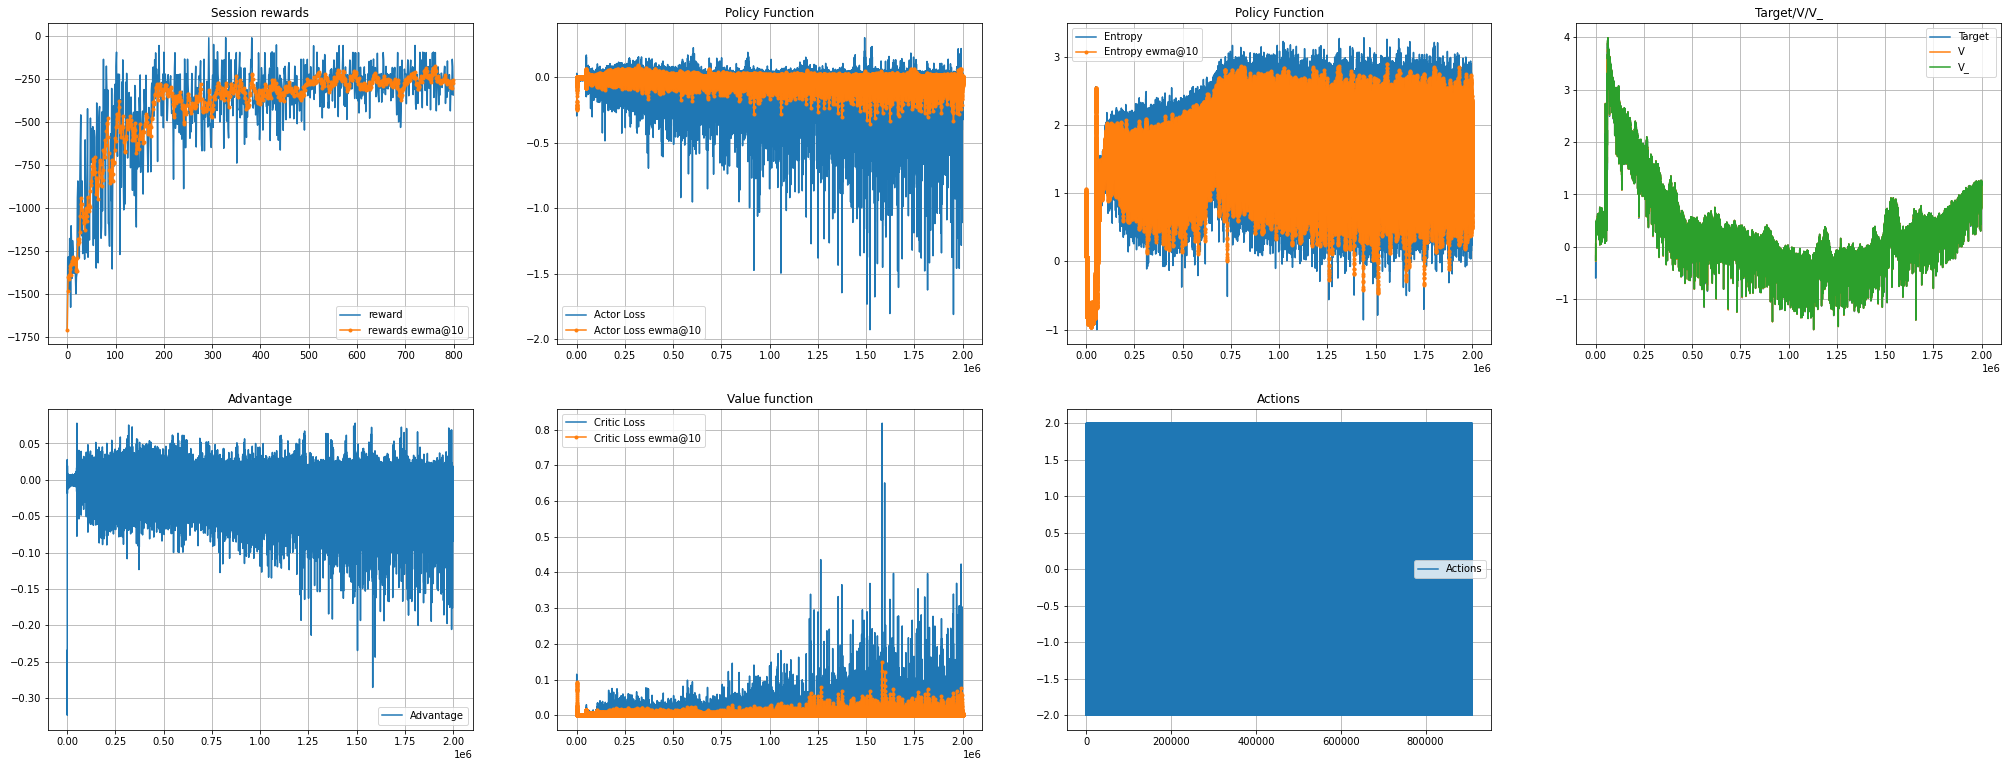

Average Reward  [-0.00660401 -0.00602426 -0.00623548 -0.00490181 -0.0032798  -0.0074553
 -0.0073629  -0.00451214 -0.00415186 -0.0028614 ]  : Total reward =  -250.93359190966672


In [11]:
for k in range(0,len(pendulumA3CList)):
    pendulumA3C = pendulumA3CList[k]
    batch_obs = env_batch.reset()
    with tqdm.trange(0, pendulumA3C.Training) as t:
        for i in t:

            batch_actions = pendulumA3C.agent.sample_actions(batch_obs)
            batch_next_obs, batch_rewards, batch_done, _ = env_batch.step(batch_actions[0])
            batch_rewards = batch_rewards /16.273604
            
            pendulumA3C.train(batch_obs,batch_actions,batch_next_obs,batch_rewards)
            batch_obs = batch_next_obs


            if len(pendulumA3C.rewards_history)> 100 :
                if np.mean(pendulumA3C.rewards_history[-100:]) >= -150:
                    print("Your agent reached the objetive")
                    break
                
            if i % 500 == 0 and i >0:
                if len(pendulumA3C.actionList) > 1000000:
                    pendulumA3C.actionList= []

                if i % 2500 == 0:
                    pendulumA3C.evaluate(n_games=3)
                    #pendulumA3C.plots(False,"")
                    #print(HYPERPARAMETERS[k][0]," - > Average Reward ",pendulumA3C.AVGR, " : Total reward = ",np.mean(pendulumA3C.rewards_history[-100:]))
                    #print("v_history : ",self.v_history[-1]," ; v__history : ",self.v__history[-1]," target_history : ",self.target_history)

                if i % 100000 == 0:
                    saver.save(sess, "D:\\Artificial_Intelligence\\RL\\AvrReward_InvertedPendulum\\model.h5")
                    pendulumA3C.plots(False,"")



    today = datetime.now()
    dt_string = today.strftime("%d_%m_%Y_%H_%M_%S")
    pendulumA3C.plots(True,str(dt_string)+"_"+HYPERPARAMETERS[k][0]+".png")
    print("Average Reward ",pendulumA3C.AVGR, " : Total reward = ",np.mean(pendulumA3C.rewards_history[-100:]))

In [ ]:
def evaluate2(agent, env, n_games=1):
    game_rewards = []
    for _ in range(n_games):
        state = env.reset()
        total_reward = 0
        while True:
            action = agent.sample_actions([state],0)
            state, reward, done, info = env.step(action)
            total_reward += reward
            if done:
                break

        game_rewards.append(total_reward)
    return game_rewards

env_monitor = gym.wrappers.Monitor(env_init, directory="D:\\Artificial_Intelligence\\RL\\AvrReward_InvertedPendulum\\videos", force=True)
final_rewards = evaluate2(pendulumA3C.agent, env_monitor, n_games=3)
env_monitor.close()

print("Final mean reward:", np.mean(final_rewards))

# 